<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
!pip install modisco

In [2]:
from __future__ import print_function, division
%matplotlib inline
/
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [3]:
import numpy as np
import modisco
import sys
import os

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [4]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [5]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [6]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

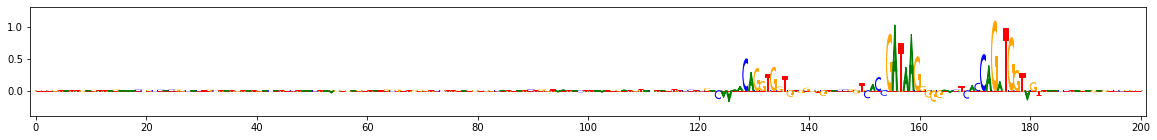

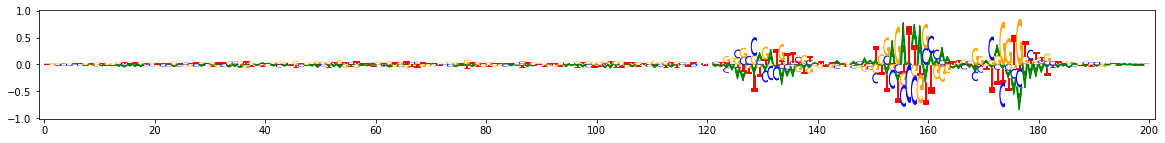

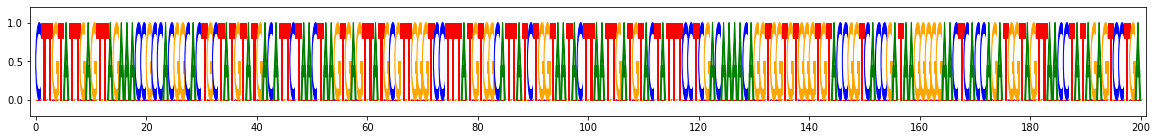

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.367886336
On task task0
Fitting - on window size 5
peak(mu)= 0.00486588878557086
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.2954850349262155 occurring at 5.7220458984375e-06 implying a frac_neg of 0.41941626448668695
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35928651361524633 occurring at -5.638343282043934e-06 implying a frac_neg of 0.5607600296390388
To be conservative, adjusted frac neg is 0.95


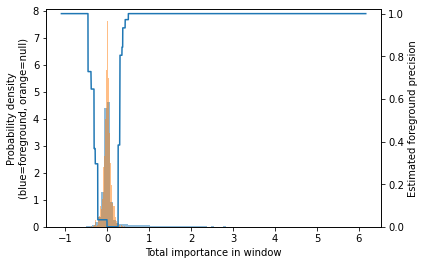

Fitting - on window size 9
peak(mu)= 0.0019212778508663174
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.31974367348777494 occurring at 6.765127182006836e-06 implying a frac_neg of 0.47003410483096586
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4258213778275138 occurring at -2.9428978450596333e-05 implying a frac_neg of 0.7416183072374903
To be conservative, adjusted frac neg is 0.95


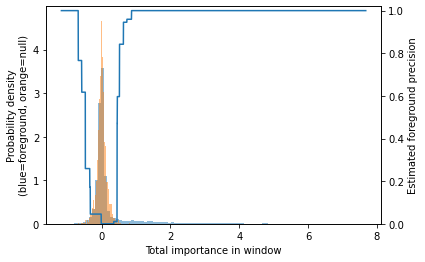

Fitting - on window size 13
peak(mu)= 0.014580504179000855
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.3469747405521833 occurring at 1.621246337890625e-05 implying a frac_neg of 0.5313343328335832
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.11749949829420027 occurring at -1.7642974853515625e-05 implying a frac_neg of 0.13314383172256963
To be conservative, adjusted frac neg is 0.95


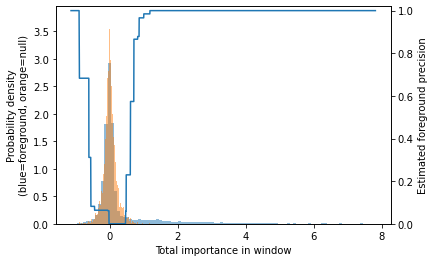

Fitting - on window size 17
peak(mu)= -0.03528579294681549
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.4006572406407763 occurring at 7.033348083496094e-06 implying a frac_neg of 0.6684943371454617
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.41327328308403144 occurring at -4.0531158447265625e-06 implying a frac_neg of 0.7043709978920574
To be conservative, adjusted frac neg is 0.95


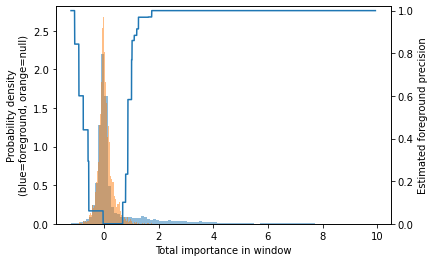

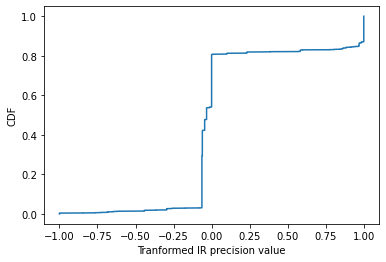

Thresholds from null dist were -0.85  and  0.85 with frac passing 0.17035
Got 318 coords
After resolving overlaps, got 318 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8499
MEMORY 0.378642432
318 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [298]
Idx to activities:  {0: '1'}
MEMORY 0.378646528
On metacluster 0
Metacluster size 298
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 298
(Round 1) Computing coarse affmat
MEMORY 0.379379712
Beginning embedding computation
Computing embeddings
MAKING A SESSION
Finished embedding computation in 0.15 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Finished affinity matrix computations in 0.02 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMOR

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6567098406851998


  8%|▊         | 4/50 [00:00<00:01, 29.02it/s]

Quality: 0.6569711466883117
Quality: 0.656986269551227


100%|██████████| 50/50 [00:01<00:00, 29.37it/s]

Got 5 clusters after round 1
Counts:
{4: 17, 0: 79, 2: 67, 3: 47, 1: 76}
MEMORY 0.45828096
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.45828096
Aggregating for cluster 0 with 79 seqlets
MEMORY 0.45828096


Trimming eliminated 0 seqlets out of 79
Skipped 16 seqlets
Aggregating for cluster 1 with 76 seqlets
MEMORY 0.45828096
Trimming eliminated 0 seqlets out of 76
Skipped 6 seqlets
Aggregating for cluster 2 with 67 seqlets
MEMORY 0.45828096
Trimming eliminated 0 seqlets out of 67
Skipped 8 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 3 with 47 seqlets
MEMORY 0.45828096
Trimming eliminated 0 seqlets out of 47
Skipped 3 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 4 with 17 seqlets
MEMORY 0.45828096
Trimming eliminated 0 seqlets out of 17
Skipped 1 seqlets
(Round 2) num seqlets: 223
(Round 2) Computing coarse affmat
MEMORY 0.45828096
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.08 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 2)

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5957562309891249
Quality: 0.5981356420164963


  6%|▌         | 3/50 [00:00<00:02, 20.16it/s]

Quality: 0.5983629186365733


100%|██████████| 50/50 [00:01<00:00, 30.32it/s]

Got 11 clusters after round 2
Counts:
{3: 27, 1: 28, 4: 26, 6: 6, 2: 27, 5: 17, 10: 2, 7: 5, 0: 80, 9: 2, 8: 3}
MEMORY 0.464105472
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.464105472
Aggregating for cluster 0 with 80 seqlets
MEMORY 0.464105472


Trimming eliminated 0 seqlets out of 80
Aggregating for cluster 1 with 28 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 28
Removed 7 duplicate seqlets
Aggregating for cluster 2 with 27 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 27
Removed 10 duplicate seqlets
Aggregating for cluster 3 with 27 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 27
Removed 8 duplicate seqlets
Aggregating for cluster 4 with 26 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 26
Removed 11 duplicate seqlets
Aggregating for cluster 5 with 17 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 17
Removed 6 duplicate seqlets
Aggregating for cluster 6 with 6 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 6
Removed 3 duplicate seqlets
Aggregating for cluster 7 with 5 seqlets
MEMORY 0.464105472
Trimming eliminated 0 seqlets out of 5
Removed 1 duplicate seqlets
Aggregating for cluster 8 with 3 seqlets
MEMORY 0.464105472

In [8]:
import h5py
import numpy as np
%matplotlib inline
import modisco

reload(modisco.coordproducers)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=[5,9,13,17],
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0"],# "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [9]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


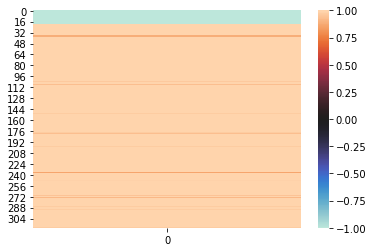

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 83
Task 0 hypothetical scores:


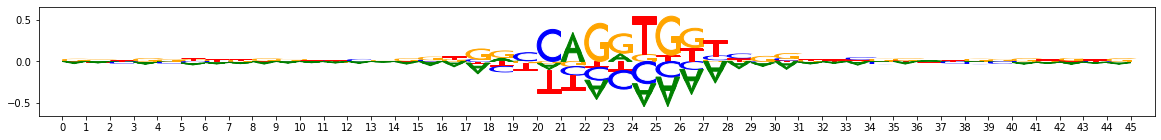

Task 0 actual importance scores:


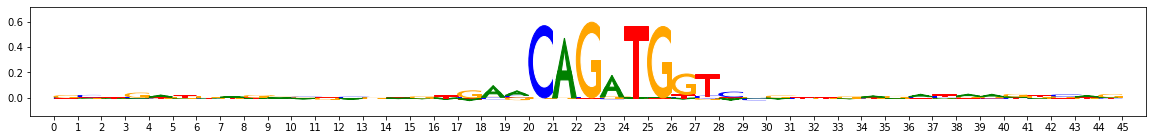

onehot, fwd and rev:


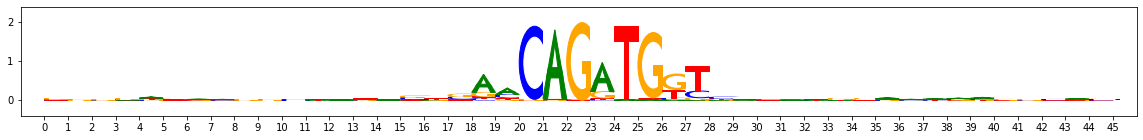

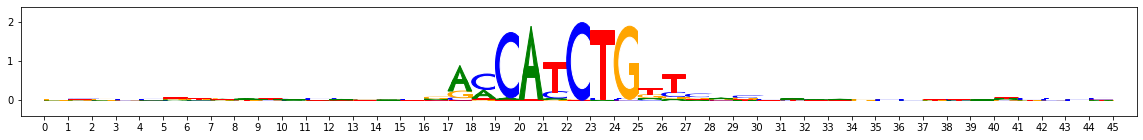

metacluster_0 pattern_1
total seqlets: 81
Task 0 hypothetical scores:


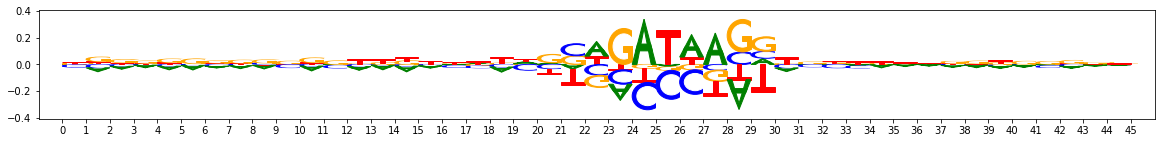

Task 0 actual importance scores:


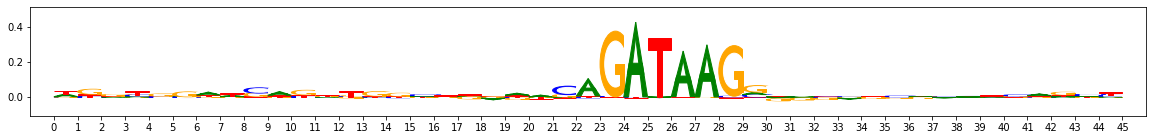

onehot, fwd and rev:


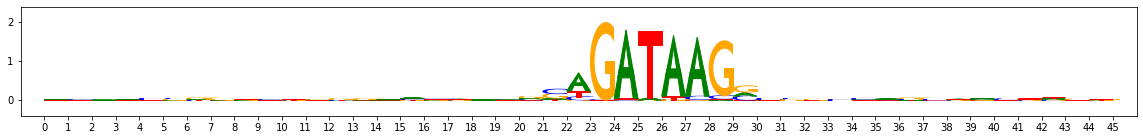

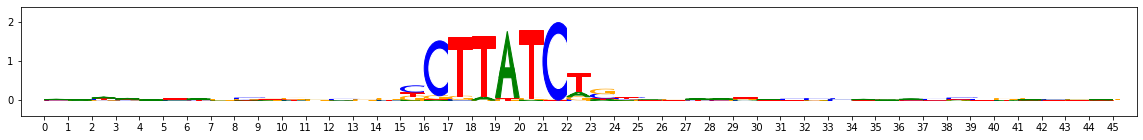

In [10]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [11]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow
reload(modisco.tfmodisco_workflow.workflow)
reload(modisco.tfmodisco_workflow)
reload(modisco)
reload(modisco.core)
reload(modisco)

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Loaded sliding window sizes: [ 5  9 13 17]
For increasing = True , the minimum IR precision was 0.2954850349262155 occurring at 5.7220458984375e-06 implying a frac_neg of 0.41941626448668695
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.31974367348777494 occurring at 6.765127182006836e-06 implying a frac_neg of 0.47003410483096586
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.3469747405521833 occurring at 1.621246337890625e-05 implying a frac_neg of 0.5313343328335832
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.4006572406407763 occurring at 7.033348083496094e-06 implying a frac_neg of 0.6684943371454617
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35928651361524633 occurring at -5.638343282043934e-06 implying a frac_neg of 0.5607600296390388
To be conservative, adju

Getting the exemplar motifs
Numseqles: 83


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  83 out of  83 | elapsed:    0.1s finished


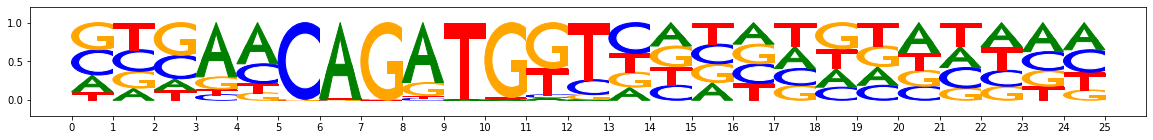

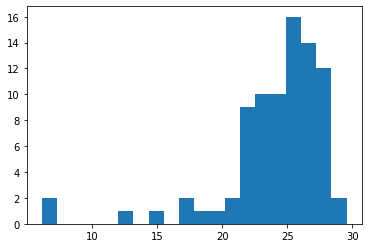

After filtering: numseqlets 79


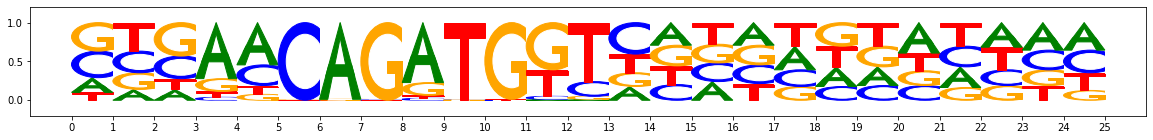

Numseqles: 81


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:    0.1s finished


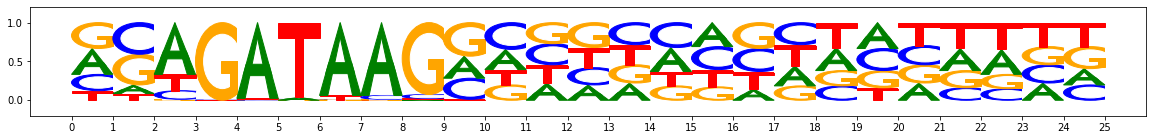

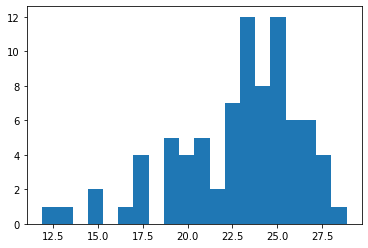

After filtering: numseqlets 79


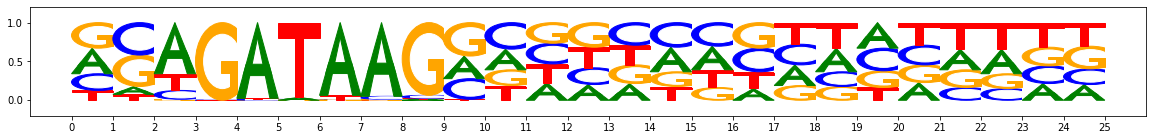

Getting labels
Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 4090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 4724 out of 4724 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.0s finished


Took 0.2695131301879883 s
Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s


Took 0.2630581855773926 s


[Parallel(n_jobs=10)]: Done 4090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 4724 out of 4724 | elapsed:    0.3s finished


In [80]:
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

SCANNING_WINDOW_WIDTH=25

instance_scorer = exemplar_based_hitscoring.prepare_instance_scorer(
    patterns=(loaded_tfmodisco_results
                .metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns),
    trim_window_size=SCANNING_WINDOW_WIDTH,
    task_names=tasks, bg_freq=background, track_set=track_set)

In [89]:
instance_scorer.get_prec_for_threshold(motif_idx=0,
                                       threshold=instance_scorer.thresholds_list[0])

array([0.07060099, 0.39592812, 0.43990814, 0.46051812, 0.46358678,
       0.477134  , 0.48289524, 0.48303023, 0.4852053 , 0.48598942,
       0.48748475, 0.48771762, 0.48974793, 0.49179656, 0.49354536,
       0.49425378, 0.49595822, 0.49642561, 0.49781634, 0.49815178,
       0.49975331, 0.50083468, 0.50237827, 0.50284284, 0.50577822,
       0.50698624, 0.50707468, 0.50790746, 0.50900005, 0.5093652 ,
       0.50968138, 0.509743  , 0.51138583, 0.51156751, 0.51275761,
       0.51303825, 0.51366061, 0.51438559, 0.51468357, 0.5147146 ,
       0.51476555, 0.51484839, 0.51511623, 0.51568231, 0.51600813,
       0.51601327, 0.51669353, 0.5168097 , 0.51685902, 0.51739562,
       0.51783374, 0.51800729, 0.51860958, 0.51861522, 0.51920012,
       0.51921313, 0.51930455, 0.51933883, 0.51937165, 0.51975825,
       0.51977374, 0.52013972, 0.52026368, 0.52042973, 0.52045827,
       0.5205568 , 0.52058087, 0.52066148, 0.52098923, 0.52103312,
       0.52116053, 0.52125391, 0.52155886, 0.52160719, 0.52212

In [91]:
from collections import defaultdict
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

CUTOFF_VALUE = 0.9
coordinates_to_be_scanned, task0_transformed_scoretrack =\
    exemplar_based_hitscoring.get_windows_to_be_scanned(
        scanning_window_width=SCANNING_WINDOW_WIDTH,
        contrib_scores=task_to_scores["task0"],
        val_transformer=(loaded_tfmodisco_results.
            multitask_seqlet_creation_results.
            task_name_to_tnt_results["task0"].val_transformer),
        cutoff_value=CUTOFF_VALUE)
        

computing the transformed score track
done computing the transformed score track
Fraction of values above cutoff: 0.1572


In [102]:
reload(exemplar_based_hitscoring)

(motifmatch_to_coordinates,
 motifmatch_to_coordinatesbyregionidx,
 motif_scores, motif_precisions,
 besthit_isrevcomp) = (
 exemplar_based_hitscoring.scan_and_process_results(
    instance_scorer=instance_scorer, track_set=track_set,
    coordinates=coordinates_to_be_scanned))

Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 9764 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 13072 out of 13072 | elapsed:    0.5s finished


Took 0.5234172344207764 s


Index 0


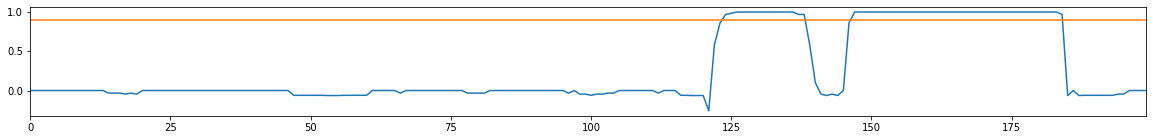

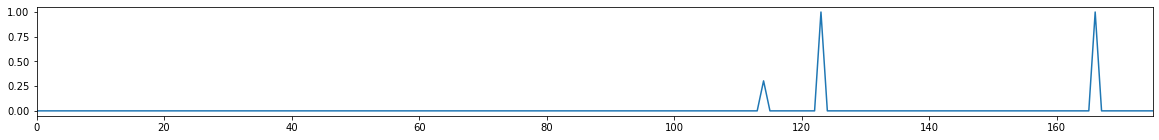

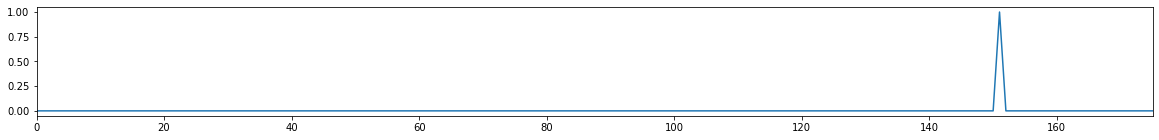

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.6288662472752831, precision_at_motif_score=0.3034387831986581, example_idx=0, start=114, end=139, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9917175077370958, precision_at_motif_score=1.0, example_idx=0, start=123, end=148, is_revcomp=False), MotifHitAndCoord(motif_idx=0, motif_score=0.5309194727615236, precision_at_motif_score=0.0, example_idx=0, start=157, end=182, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9904592739684515, precision_at_motif_score=1.0, example_idx=0, start=166, end=191, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9979175245102603, precision_at_motif_score=1.0, example_idx=0, start=151, end=176, is_revcomp=False)]


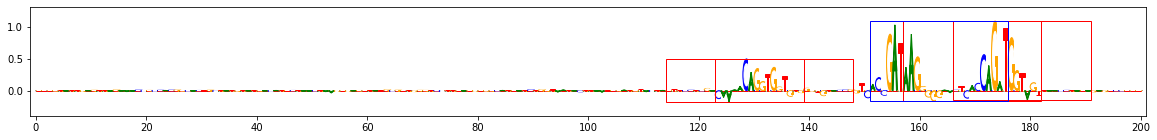

Index 1


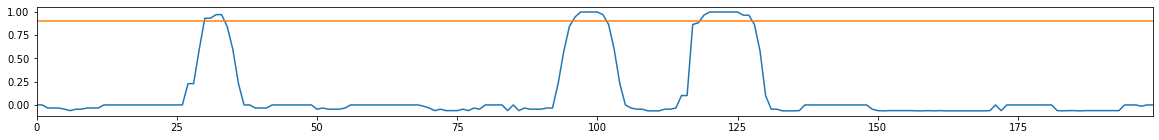

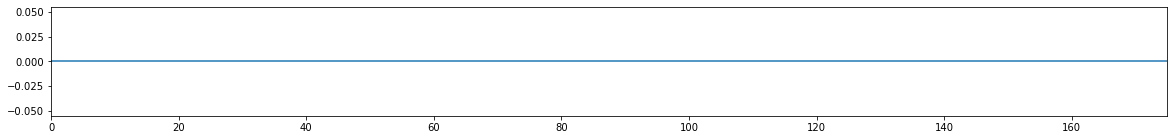

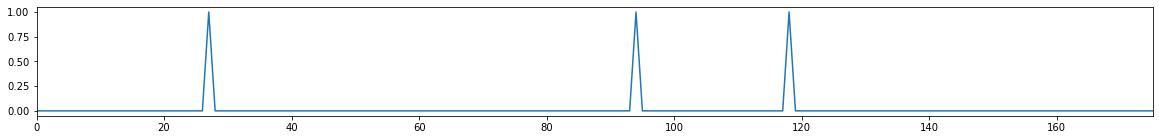

tal hits: []
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9955329648255107, precision_at_motif_score=1.0, example_idx=1, start=27, end=52, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.9984405620577878, precision_at_motif_score=1.0, example_idx=1, start=94, end=119, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.9995610910908511, precision_at_motif_score=1.0, example_idx=1, start=118, end=143, is_revcomp=False)]


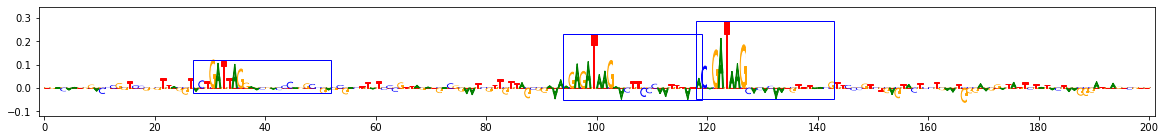

Index 2


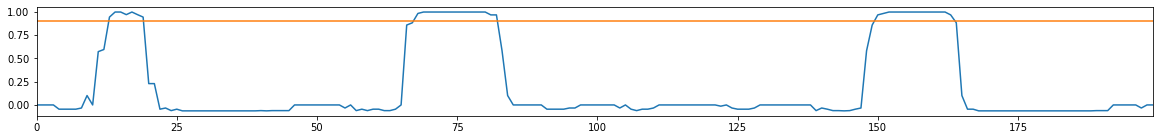

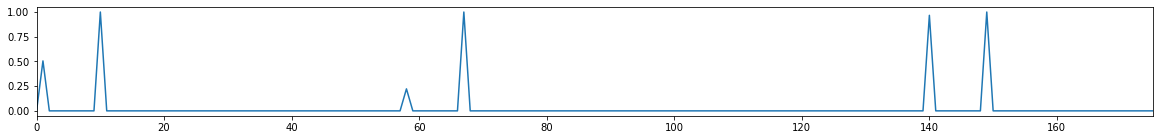

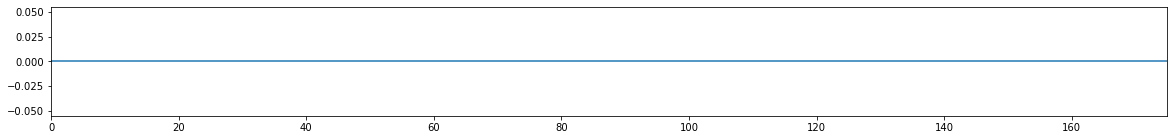

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.6940629318048525, precision_at_motif_score=0.5054178960428508, example_idx=2, start=1, end=26, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9892230296698091, precision_at_motif_score=1.0, example_idx=2, start=10, end=35, is_revcomp=False), MotifHitAndCoord(motif_idx=0, motif_score=0.602743025674392, precision_at_motif_score=0.22250912915793472, example_idx=2, start=58, end=83, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9985116869126707, precision_at_motif_score=1.0, example_idx=2, start=67, end=92, is_revcomp=False), MotifHitAndCoord(motif_idx=0, motif_score=0.8429574686878377, precision_at_motif_score=0.9666926784028752, example_idx=2, start=140, end=165, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9994729032358728, precision_at_motif_score=1.0, example_idx=2, start=149, end=174, is_revcomp=False)]
gata hits: []


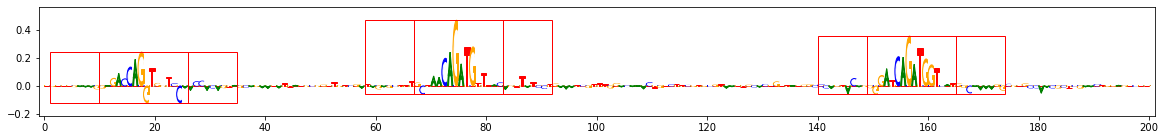

Index 3


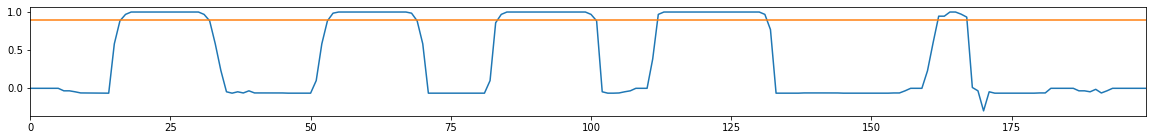

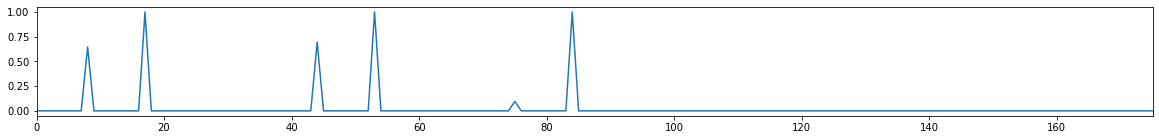

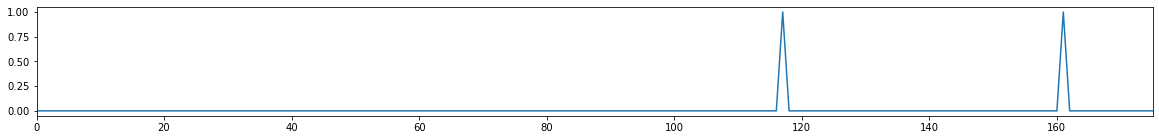

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.7396519082923678, precision_at_motif_score=0.6466523942825104, example_idx=3, start=8, end=33, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9925835180934502, precision_at_motif_score=1.0, example_idx=3, start=17, end=42, is_revcomp=False), MotifHitAndCoord(motif_idx=0, motif_score=0.7552320976497837, precision_at_motif_score=0.6949197693348133, example_idx=3, start=44, end=69, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9989573753258589, precision_at_motif_score=1.0, example_idx=3, start=53, end=78, is_revcomp=False), MotifHitAndCoord(motif_idx=0, motif_score=0.5618840852404383, precision_at_motif_score=0.09592826695380294, example_idx=3, start=75, end=100, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.997376173301304, precision_at_motif_score=1.0, example_idx=3, start=84, end=109, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9998595508158103, precisio

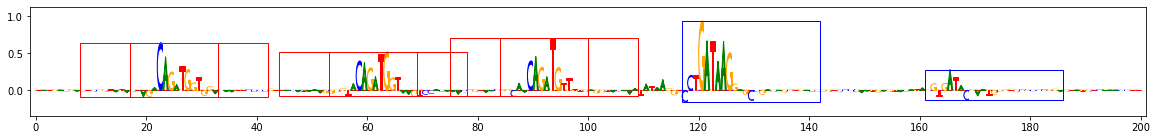

Index 4


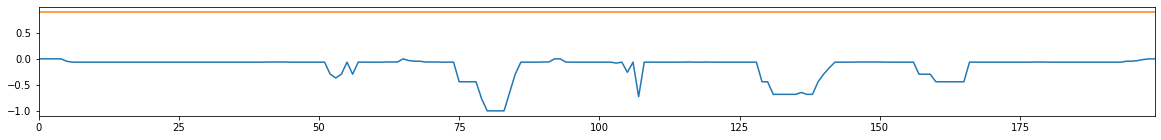

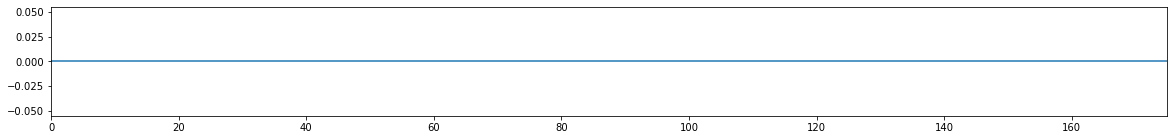

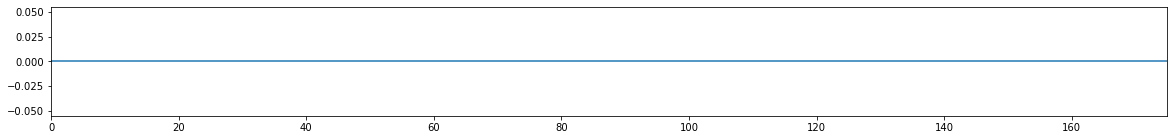

tal hits: []
gata hits: []


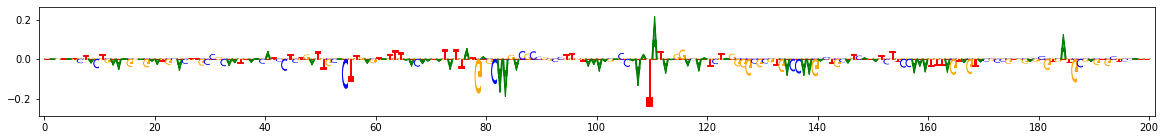

Index 5


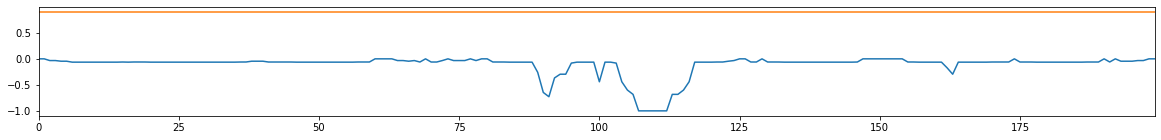

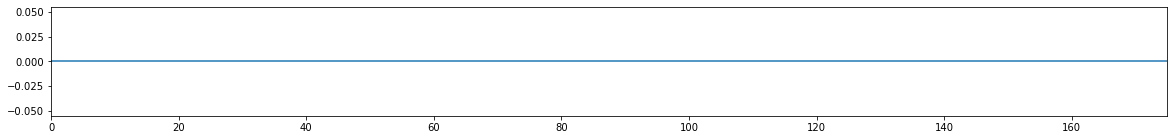

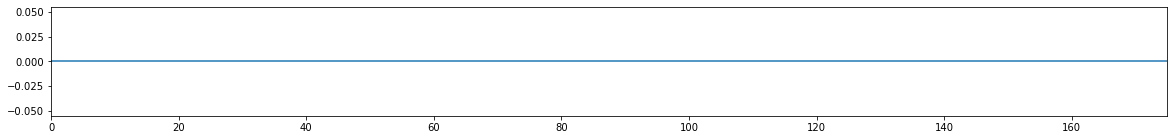

tal hits: []
gata hits: []


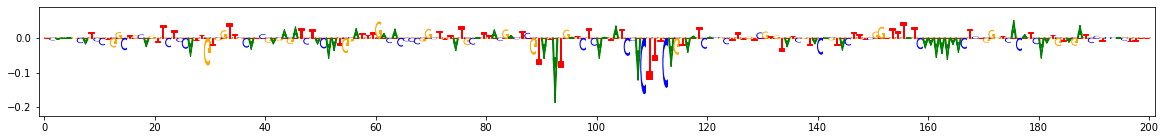

Index 6


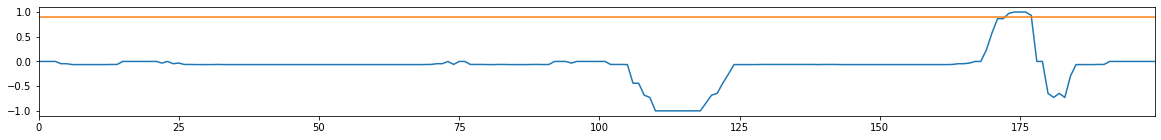

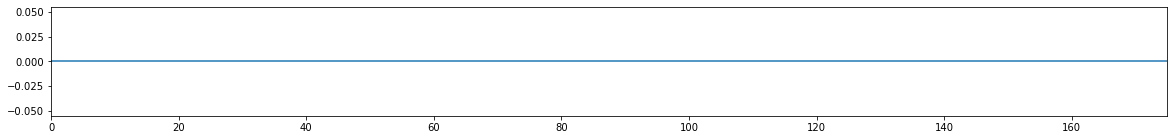

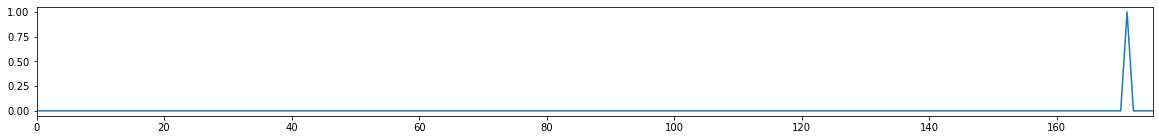

tal hits: []
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.8735744116604658, precision_at_motif_score=1.0, example_idx=6, start=171, end=196, is_revcomp=False)]


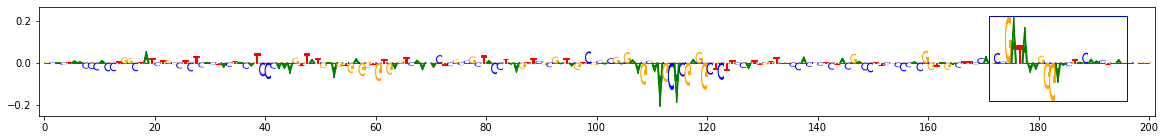

Index 7


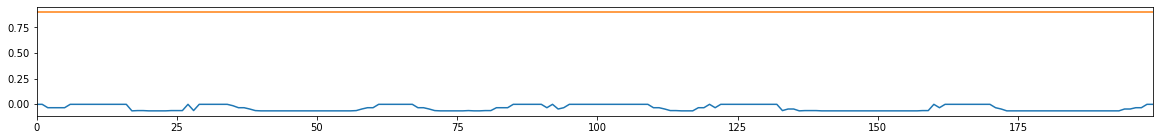

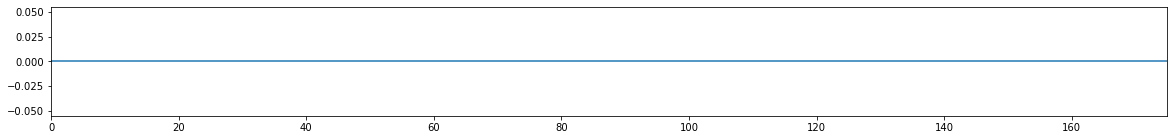

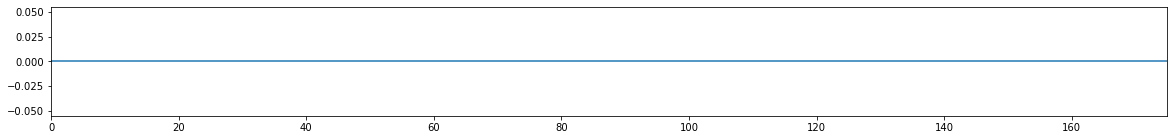

tal hits: []
gata hits: []


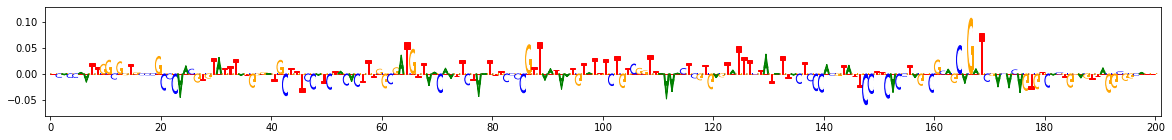

Index 8


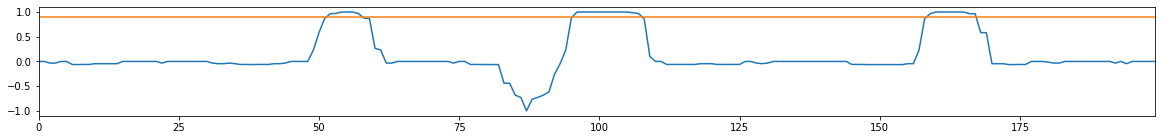

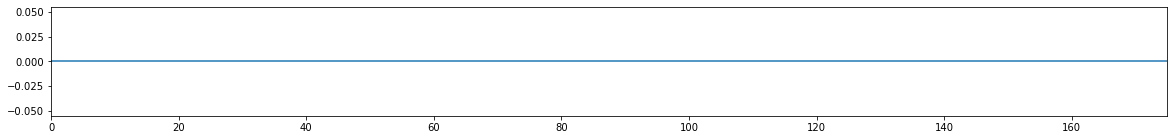

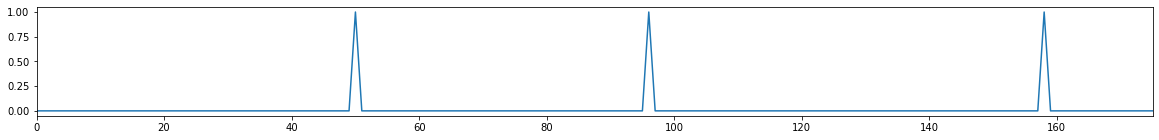

tal hits: []
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9981759716448624, precision_at_motif_score=1.0, example_idx=8, start=50, end=75, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.999767182191173, precision_at_motif_score=1.0, example_idx=8, start=96, end=121, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.9994275624967489, precision_at_motif_score=1.0, example_idx=8, start=158, end=183, is_revcomp=False)]


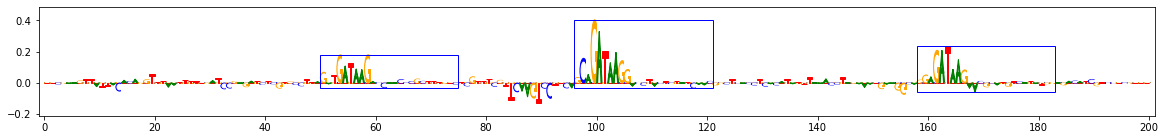

Index 9


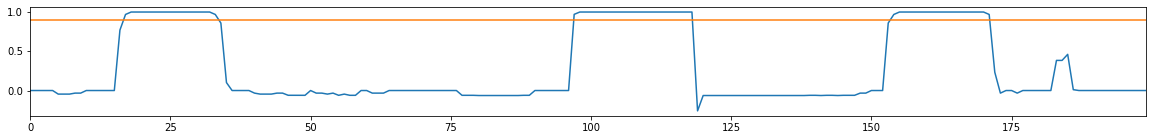

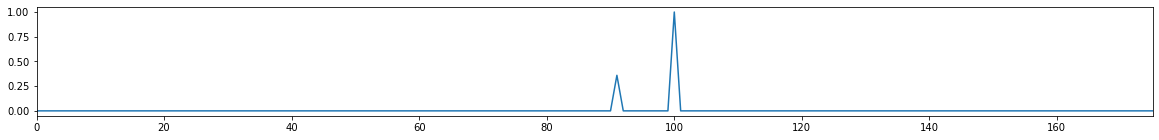

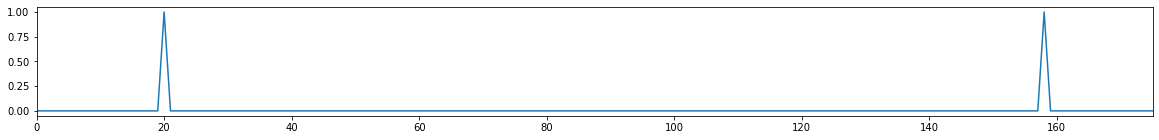

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.6470172153354097, precision_at_motif_score=0.3596704221616013, example_idx=9, start=91, end=116, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9985564582348262, precision_at_motif_score=1.0, example_idx=9, start=100, end=125, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9969703204925457, precision_at_motif_score=1.0, example_idx=9, start=20, end=45, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.9975591077917395, precision_at_motif_score=1.0, example_idx=9, start=158, end=183, is_revcomp=False)]


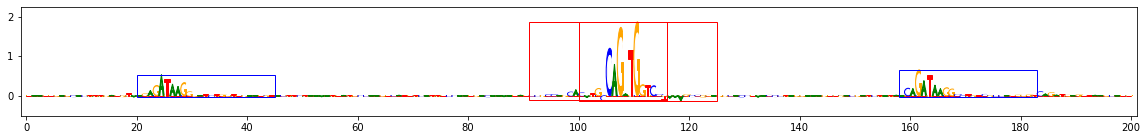

Index 10


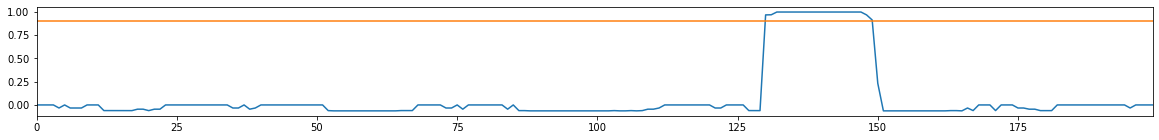

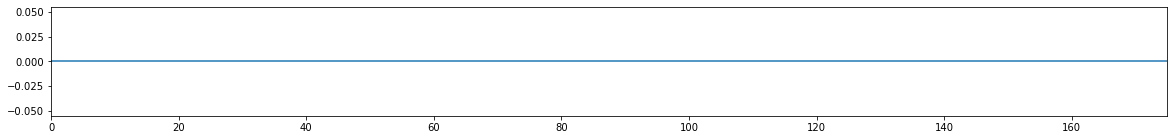

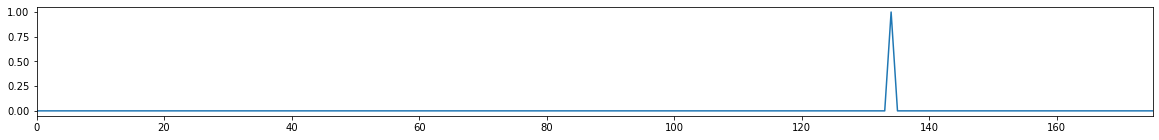

tal hits: []
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.998810229513942, precision_at_motif_score=1.0, example_idx=10, start=134, end=159, is_revcomp=False)]


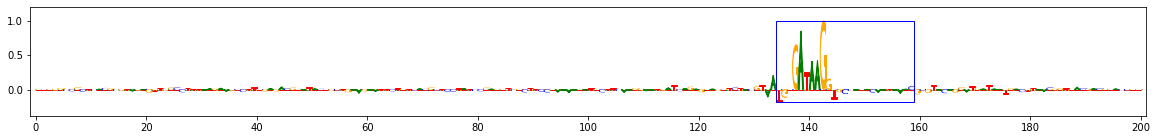

Index 11


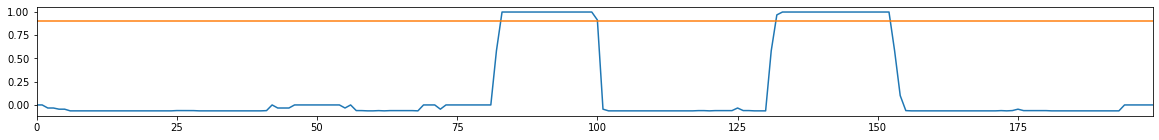

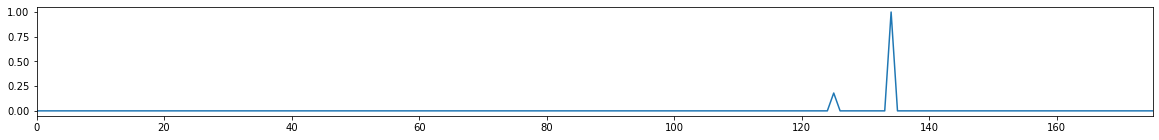

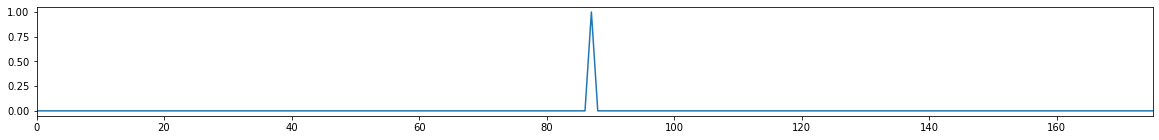

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.5891716112073493, precision_at_motif_score=0.18046493206611938, example_idx=11, start=125, end=150, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9986918443818005, precision_at_motif_score=1.0, example_idx=11, start=134, end=159, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9971011527533985, precision_at_motif_score=1.0, example_idx=11, start=87, end=112, is_revcomp=False)]


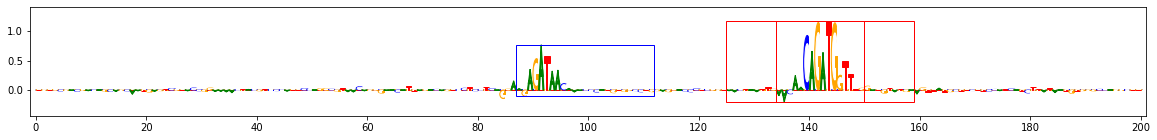

Index 12


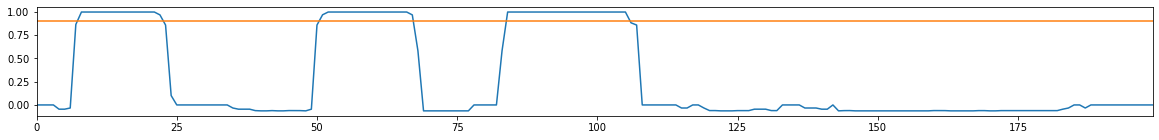

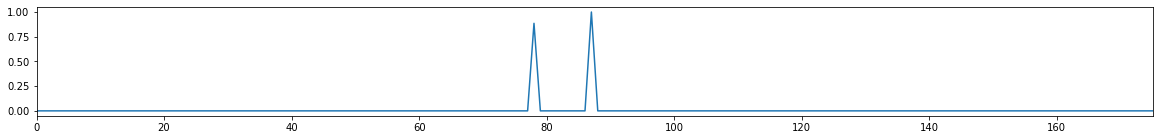

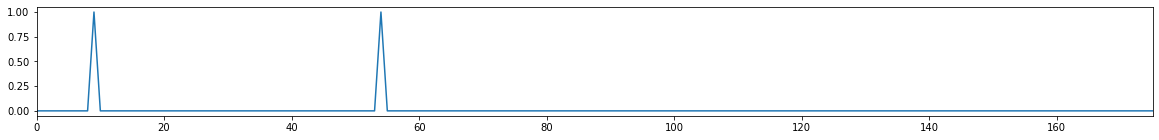

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.8168112706641384, precision_at_motif_score=0.8856918434803535, example_idx=12, start=78, end=103, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9988549902881714, precision_at_motif_score=1.0, example_idx=12, start=87, end=112, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9991710670547282, precision_at_motif_score=1.0, example_idx=12, start=9, end=34, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.9987750034461544, precision_at_motif_score=1.0, example_idx=12, start=54, end=79, is_revcomp=False)]


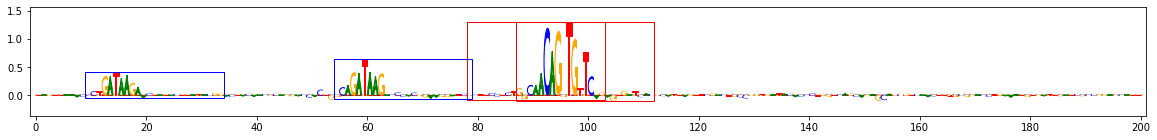

Index 13


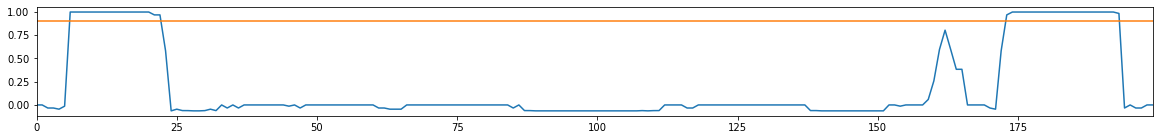

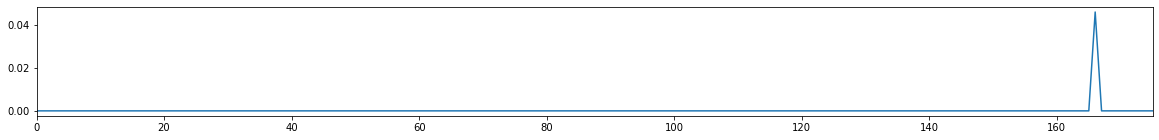

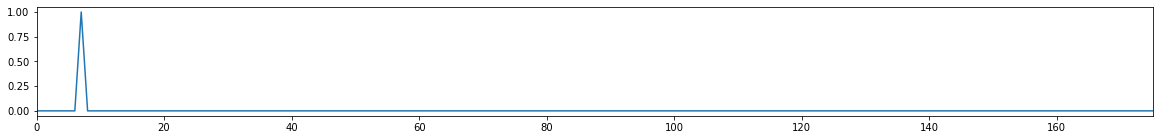

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.5458333821414315, precision_at_motif_score=0.04620324188764962, example_idx=13, start=166, end=191, is_revcomp=True)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9967916625348455, precision_at_motif_score=1.0, example_idx=13, start=7, end=32, is_revcomp=False)]


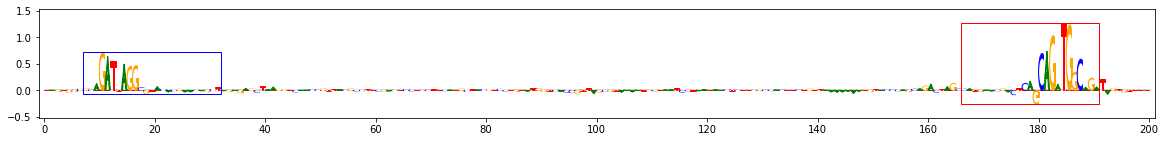

Index 14


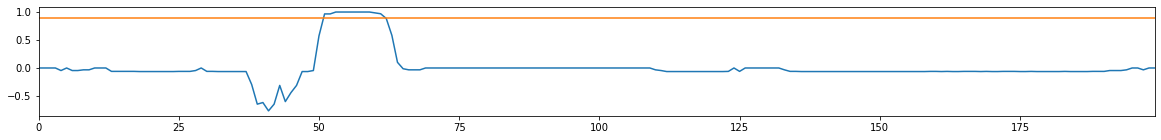

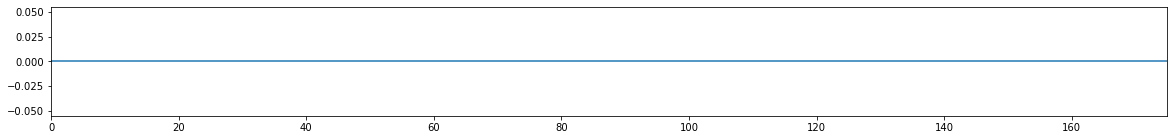

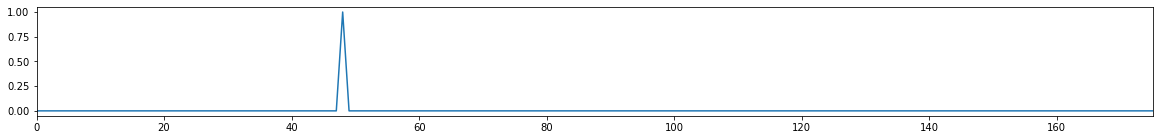

tal hits: []
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9754941959328381, precision_at_motif_score=1.0, example_idx=14, start=48, end=73, is_revcomp=False)]


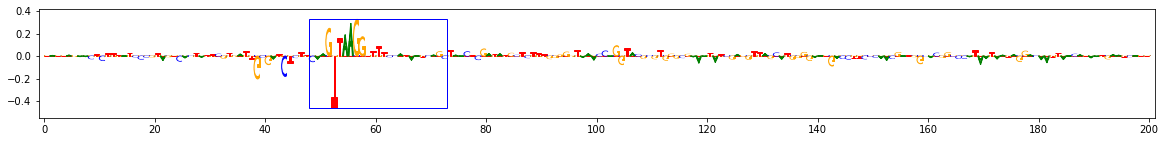

Index 15


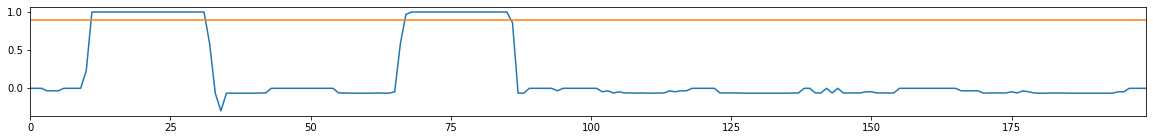

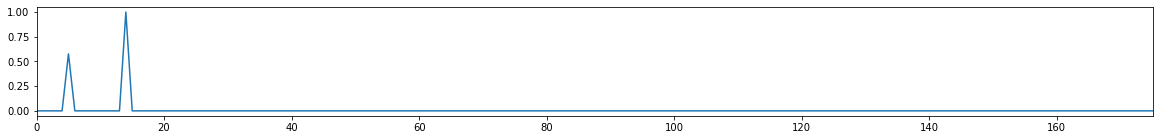

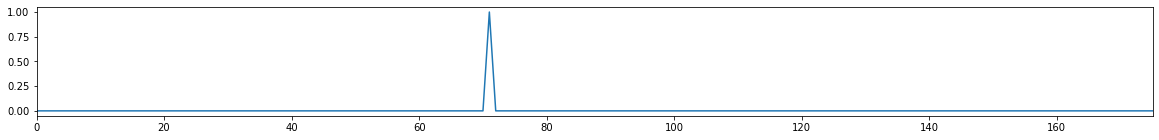

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.7170648136313933, precision_at_motif_score=0.5766776497955829, example_idx=15, start=5, end=30, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9977790829683072, precision_at_motif_score=1.0, example_idx=15, start=14, end=39, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9987429074356223, precision_at_motif_score=1.0, example_idx=15, start=71, end=96, is_revcomp=False)]


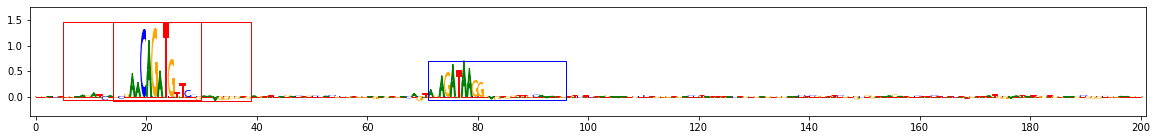

Index 16


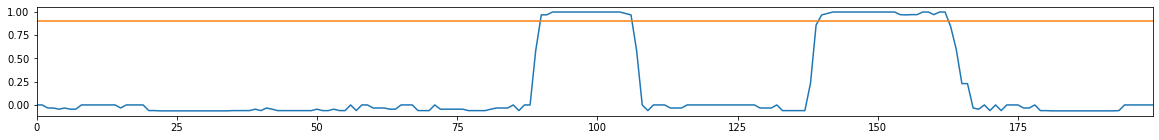

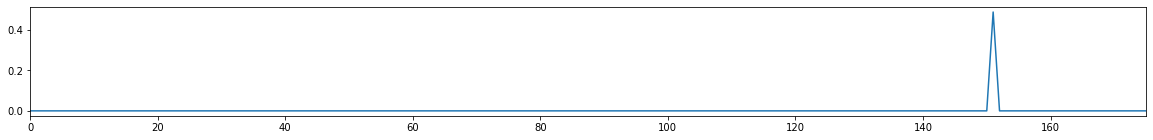

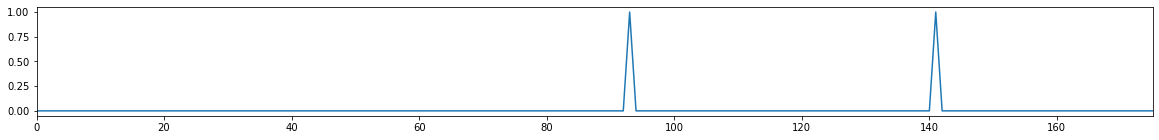

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.6887544010946807, precision_at_motif_score=0.4889720854762052, example_idx=16, start=151, end=176, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9987333675412913, precision_at_motif_score=1.0, example_idx=16, start=93, end=118, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.9939796094680625, precision_at_motif_score=1.0, example_idx=16, start=141, end=166, is_revcomp=False)]


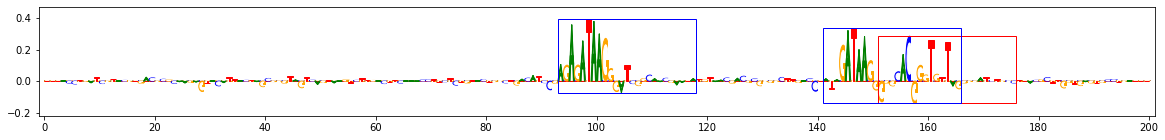

Index 17


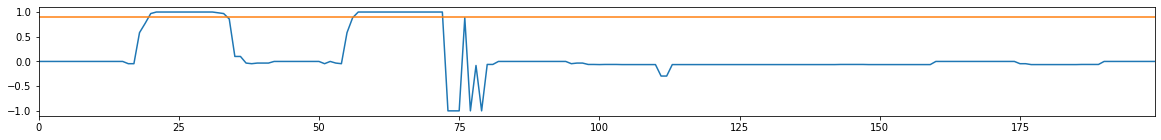

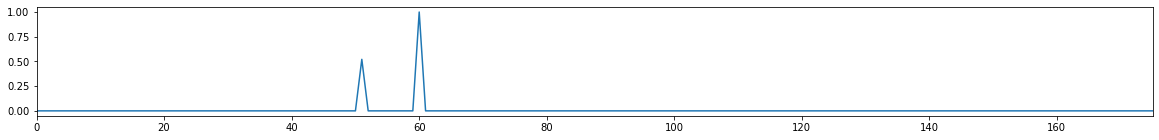

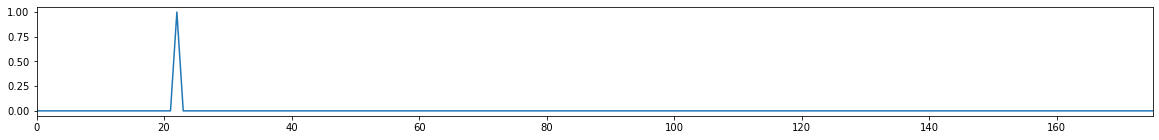

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.6991793707241977, precision_at_motif_score=0.5212686068774202, example_idx=17, start=51, end=76, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9890048345603109, precision_at_motif_score=1.0, example_idx=17, start=60, end=85, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9809579313367828, precision_at_motif_score=1.0, example_idx=17, start=22, end=47, is_revcomp=False)]


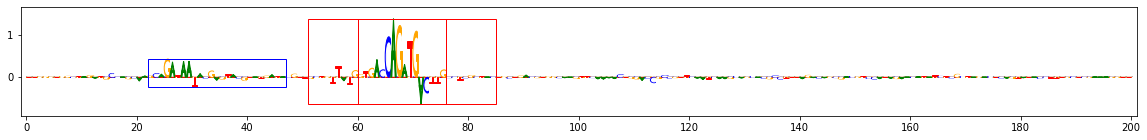

Index 18


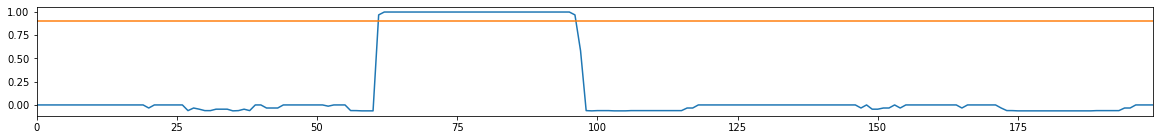

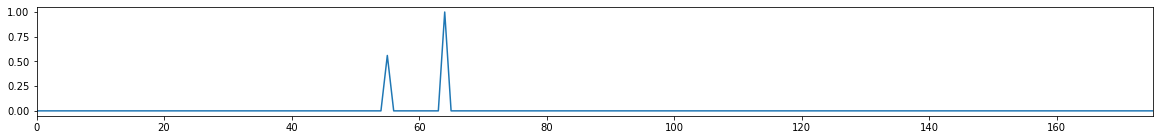

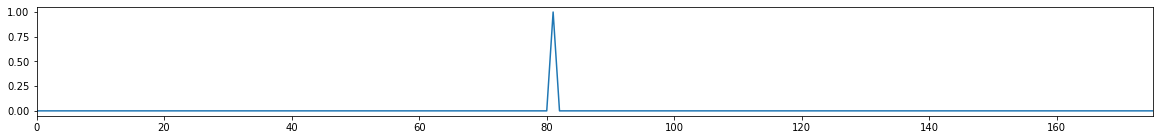

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.7118732661068118, precision_at_motif_score=0.5605942527506326, example_idx=18, start=55, end=80, is_revcomp=True), MotifHitAndCoord(motif_idx=0, motif_score=0.9945691767749727, precision_at_motif_score=1.0, example_idx=18, start=64, end=89, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9987356972101512, precision_at_motif_score=1.0, example_idx=18, start=81, end=106, is_revcomp=False)]


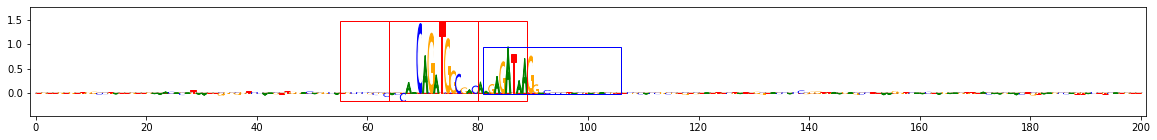

Index 19


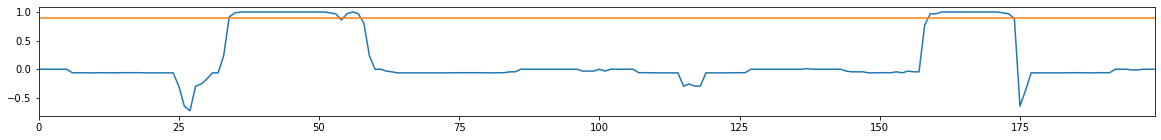

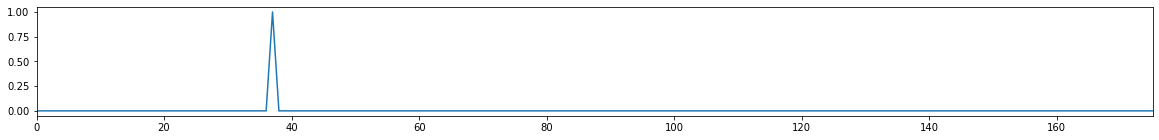

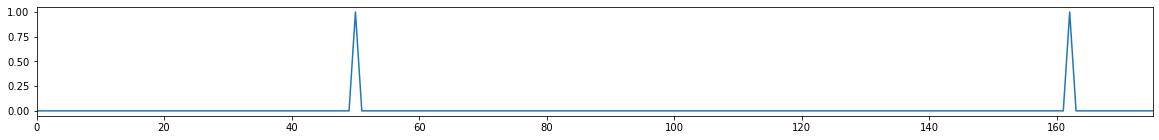

tal hits: [MotifHitAndCoord(motif_idx=0, motif_score=0.8537087137453788, precision_at_motif_score=1.0, example_idx=19, start=37, end=62, is_revcomp=False)]
gata hits: [MotifHitAndCoord(motif_idx=1, motif_score=0.9060133574960566, precision_at_motif_score=1.0, example_idx=19, start=50, end=75, is_revcomp=False), MotifHitAndCoord(motif_idx=1, motif_score=0.999371099425408, precision_at_motif_score=1.0, example_idx=19, start=162, end=187, is_revcomp=False)]


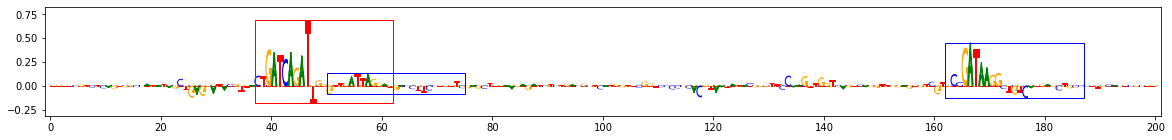

In [103]:
reload(modisco.visualization.viz_sequence)
reload(modisco.visualization)

def visualize_idx(idx_to_viz):
    viz_sequence.plot_score_track(task0_transformed_scoretrack[idx_to_viz],
                                  threshold=CUTOFF_VALUE)
    
    viz_sequence.plot_score_track(motif_precisions[idx_to_viz][:,0])
    viz_sequence.plot_score_track(motif_precisions[idx_to_viz][:,1])
    
    print("tal hits:", motifmatch_to_coordinatesbyregionidx[0][idx_to_viz])
    print("gata hits:", motifmatch_to_coordinatesbyregionidx[1][idx_to_viz])
    viz_sequence.plot_weights(task_to_scores["task0"][idx_to_viz],
                              highlight={
                                  'red': [(x.start, x.end) for x in
                                          motifmatch_to_coordinatesbyregionidx[0][idx_to_viz]],
                                  'blue': [(x.start, x.end) for x in
                                          motifmatch_to_coordinatesbyregionidx[1][idx_to_viz]]
                              },
                              subticks_frequency=20)

for idx_to_viz in range(20):
    print("Index",idx_to_viz)
    visualize_idx(idx_to_viz)